# Automatic autoencoding variational Bayes for latent dirichlet allocation with PyMC3

For probabilistic models with latent variables, autoencoding variational Bayes (AEVB; Kingma and Welling, 2014) is an algorithm which allows us to perform inference efficiently for large datasets with an encoder. In AEVB, the encoder is used to infer variational parameters of approximate posterior on latent variables from given samples. By using tunable and flexible encoders such as multilayer perceptrons (MLPs), AEVB approximates complex variational posterior based on mean-field approximation, which does not utilize analytic representations of the true posterior. Combining AEVB with ADVI (Kucukelbir et al., 2015), we can perform posterior inference on almost arbitrary probabilistic models involving continuous latent variables. 

I have implemented AEVB for ADVI with mini-batch on PyMC3. To demonstrate flexibility of this approach, we will apply this to latent dirichlet allocation (LDA; Blei et al., 2003) for modeling documents. In the LDA model, each document is assumed to be generated from a multinomial distribution, whose parameters are treated as latent variables. By using AEVB with an MLP as an encoder, we will fit the LDA model to the 20-newsgroups dataset. 

In this example, extracted topics by AEVB seem to be qualitatively comparable to those with a standard LDA implementation, i.e., online VB implemented on scikit-learn. Unfortunately, the predictive accuracy of unseen words is less than the standard implementation of LDA, it might be due to the mean-field approximation. However, the combination of AEVB and ADVI allows us to quickly apply more complex probabilistic models than LDA to big data with the help of mini-batches. I hope this notebook will attract readers, especially practitioners working on a variety of machine learning tasks, to probabilistic programming and PyMC3. 

In [19]:
%matplotlib inline
import sys, os
# unfortunately I was not able to run it on GPU due to overflow problems
%env THEANO_FLAGS=device=cpu,floatX=float64
import theano

from collections import OrderedDict
from copy import deepcopy
import numpy as np
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')

env: THEANO_FLAGS=device=cpu,floatX=float64


## Dataset
Here, we will use the 20-newsgroups dataset. This dataset can be obtained by using functions of scikit-learn. The below code is partially adopted from an example of scikit-learn (http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html). We set the number of words in the vocabulary to 1000.  

In [20]:
# The number of words in the vocabulary
n_words = 1000

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words,
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 1.181s.
Extracting tf features for LDA...
done in 1.655s.


Each document is represented by 1000-dimensional term-frequency vector. Let's check the data. 

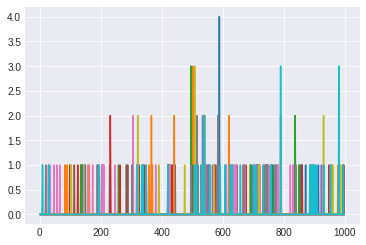

In [21]:
plt.plot(tf[:10, :].toarray().T);

We split the whole documents into training and test sets. The number of tokens in the training set is 480K. Sparsity of the term-frequency document matrix is 0.025%, which implies almost all components in the term-frequency matrix is zero. 

In [22]:
n_samples_tr = 10000
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for test = {}'.format(docs_te.shape[0]))

n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

Number of docs for training = 10000
Number of docs for test = 1314
Number of tokens in training set = 480263
Sparsity = 0.0253936


## Log-likelihood of documents for LDA
For a document $d$ consisting of tokens $w$, the log-likelihood of the LDA model with $K$ topics is given as
\begin{eqnarray}
    \log p\left(d|\theta_{d},\beta\right) & = & \sum_{w\in d}\log\left[\sum_{k=1}^{K}\exp\left(\log\theta_{d,k} + \log \beta_{k,w}\right)\right]+const, 
\end{eqnarray}
where $\theta_{d}$ is the topic distribution for document $d$ and $\beta$ is the word distribution for the $K$ topics. We define a function that returns a tensor of the log-likelihood of documents given $\theta_{d}$ and $\beta$. 

In [23]:
def logp_lda_doc(beta, theta):
    """Returns the log-likelihood function for given documents. 
    
    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)
    
    Parameters
    ----------
    beta : tensor (K x V)
        Word distributions. 
    theta : tensor (D x K)
        Topic distributions for documents. 
    """
    def ll_docs_f(docs):
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        ll_docs = vfreqs * pmmath.logsumexp(
            tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()
        
        # Per-word log-likelihood times num of tokens in the whole dataset
        return tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens
    
    return ll_docs_f

In the inner function, the log-likelihood is scaled for mini-batches by the number of tokens in the dataset. 

## LDA model
With the log-likelihood function, we can construct the probabilistic model for LDA. `doc_t` works as a placeholder to which documents in a mini-batch are set.  

For ADVI, each of random variables $\theta$ and $\beta$, drawn from Dirichlet distributions, is transformed into unconstrained real coordinate space. To do this, by default, PyMC3 uses a centered stick-breaking transformation. Since these random variables are on a simplex, the dimension of the unconstrained coordinate space is the original dimension minus 1. For example, the dimension of $\theta_{d}$ is the number of topics (`n_topics`) in the LDA model, thus the transformed space has dimension `(n_topics - 1)`. It shuold be noted that, in this example, we use `t_stick_breaking`, which is a numerically stable version of `stick_breaking` used by default. This is required to work ADVI for the LDA model. 

The variational posterior on these transformed parameters is represented by a spherical Gaussian distributions (meanfield approximation). Thus, the number of variational parameters of $\theta_{d}$, the latent variable for each document, is `2 * (n_topics - 1)` for means and standard deviations. 

In the last line of the below cell, `DensityDist` class is used to define the log-likelihood function of the model. The second argument is a Python function which takes observations (a document matrix in this example) and returns the log-likelihood value. This function is given as a return value of `logp_lda_doc(beta, theta)`, which has been defined above. 

In [24]:
n_topics = 10
# we have sparse dataset. It's better to have dence batch so that all words accure there
minibatch_size = 128

# defining minibatch
doc_t_minibatch = pm.Minibatch(docs_tr.toarray(), minibatch_size)
doc_t = shared(docs_tr.toarray()[:minibatch_size])
with pm.Model() as model:
    theta = Dirichlet('theta', a=pm.floatX((1.0 / n_topics) * np.ones((minibatch_size, n_topics))), 
                      shape=(minibatch_size, n_topics), transform=t_stick_breaking(1e-9),
                      # do not forget scaling
                      total_size=n_samples_tr)
    beta = Dirichlet('beta', a=pm.floatX((1.0 / n_topics) * np.ones((n_topics, n_words))), 
                     shape=(n_topics, n_words), transform=t_stick_breaking(1e-9))
    # Note, that we defined likelihood with scaling, so here we need no additional `total_size` kwarg
    doc = pm.DensityDist('doc', logp_lda_doc(beta, theta), observed=doc_t)

## Encoder
Given a document, the encoder calculates variational parameters of the (transformed) latent variables, more specifically, parameters of Gaussian distributions in the unconstrained real coordinate space. The `encode()` method is required to output variational means and stds as a tuple, as shown in the following code. As explained above, the number of variational parameters is `2 * (n_topics) - 1`. Specifically, the shape of `zs_mean` (or `zs_std`) in the method is `(minibatch_size, n_topics - 1)`. It should be noted that `zs_std` is defined as $\rho = log(exp(std) - 1)$ in `ADVI` and bounded to be positive. The inverse parametrization is $std = log(1+exp(\rho))$ and considered to be numericaly stable.

To enhance generalization ability to unseen words, a bernoulli corruption process is applied to the inputted documents. Unfortunately, I have never see any significant improvement with this. 

In [25]:
class LDAEncoder:
    """Encode (term-frequency) document vectors to variational means and (log-transformed) stds. 
    """
    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b1')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption
    
    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs], 
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics - 1)))
        hs = tt.tanh(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_rho = zs[:, (self.n_topics - 1):]
        return {'mu': zs_mean, 'rho':zs_rho}
        
    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]

To feed the output of the encoder to the variational parameters of $\theta$, we set an OrderedDict of tuples as below.  

In [26]:
encoder = LDAEncoder(n_words=n_words, n_hidden=100, n_topics=n_topics, p_corruption=0.0)
local_RVs = OrderedDict([(theta, encoder.encode(doc_t))])
local_RVs

OrderedDict([(theta,
              {'mu': Subtensor{::, :int64:}.0,
               'rho': Subtensor{::, int64::}.0})])

`theta` is the random variable defined in the model creation and is a key of an entry of the `OrderedDict`. The value `(encoder.encode(doc_t), n_samples_tr / minibatch_size)` is a tuple of a theano expression and a scalar. The theano expression `encoder.encode(doc_t)` is the output of the encoder given inputs (documents). The scalar `n_samples_tr / minibatch_size` specifies the scaling factor for mini-batches. 

ADVI optimizes the parameters of the encoder. They are passed to the function for ADVI. 

In [27]:
encoder_params = encoder.get_params()
encoder_params

[w0, b0, w1, b1]

## AEVB with ADVI

In [28]:
η = .1
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.7)

with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
inference.fit(10000, callbacks=[reduce_rate], obj_optimizer=pm.sgd(learning_rate=s), 
              more_obj_params=encoder_params, total_grad_norm_constraint=200, 
              more_replacements={doc_t:doc_t_minibatch})

Average Loss = 2.9916e+06: 100%|██████████| 10000/10000 [03:31<00:00, 47.30it/s]
Finished [100%]: Average Loss = 2.995e+06


In [29]:
print(approx)

Approximation{MeanFieldGroup[None, 9] & MeanFieldGroup[9990]}


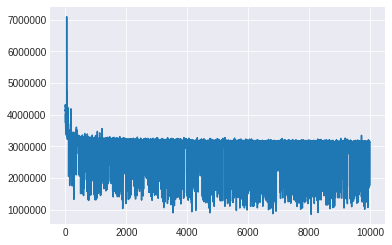

In [30]:
plt.plot(approx.hist[10:]);

## Extraction of characteristic words of topics based on posterior samples
By using estimated variational parameters, we can draw samples from the variational posterior. To do this, we use function `sample_vp()`. Here we use this function to obtain posterior mean of the word-topic distribution $\beta$ and show top-10 words frequently appeared in the 10 topics. 

To apply the above function for the LDA model, we redefine the probabilistic model because the number of documents to be tested changes. Since variational parameters have already been obtained, we can reuse them for sampling from the approximate posterior distribution. 

In [31]:
def print_top_words(beta, feature_names, n_top_words=10):
    for i in range(len(beta)):
        print(("Topic #%d: " % i) + " ".join([feature_names[j]
            for j in beta[i].argsort()[:-n_top_words - 1:-1]]))


doc_t.set_value(docs_tr.toarray())
samples = pm.sample_approx(approx, draws=100)
beta_pymc3 = samples['beta'].mean(axis=0)

print_top_words(beta_pymc3, feature_names)

Topic #0: people think god don just know said time say government
Topic #1: use key windows drive using file chip scsi like bit
Topic #2: just like don year good time car think team game
Topic #3: edu space information com available nasa list new ftp mail
Topic #4: know thanks does like mail don just help need post
Topic #5: ax max g9v b8f pl cx bhj 75u a86 chz
Topic #6: just like don new good know think use ve price
Topic #7: db just like don cs bh know good think does
Topic #8: 00 10 25 15 20 11 16 12 14 50
Topic #9: like just don know new good does think use thanks


We compare these topics to those obtained by a standard LDA implementation on scikit-learn, which is based on an online stochastic variational inference (Hoffman et al., 2013). We can see that estimated words in the topics are qualitatively similar. 

In [32]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
%time lda.fit(docs_tr)
beta_sklearn = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

print_top_words(beta_sklearn, feature_names)

CPU times: user 9.28 s, sys: 16 ms, total: 9.29 s
Wall time: 9.29 s
Topic #0: people gun armenian war armenians turkish states said state 000
Topic #1: government people law mr president use don think right public
Topic #2: space science nasa program data research center output earth launch
Topic #3: key car chip used keys bit bike clipper use number
Topic #4: edu file com mail available ftp image files information list
Topic #5: god people does jesus think believe don say just know
Topic #6: windows drive use thanks does card know problem like db
Topic #7: ax max g9v pl b8f a86 cx 34u 145 1t
Topic #8: just don like know think good time ve people year
Topic #9: 00 10 25 15 20 12 11 16 14 17


## Predictive distribution
In some papers (e.g., Hoffman et al. 2013), the predictive distribution of held-out words was proposed as a quantitative measure for goodness of the model fitness. The log-likelihood function for tokens of the held-out word can be calculated with posterior means of $\theta$ and $\beta$. The validity of this is explained in (Hoffman et al. 2013). 

In [33]:
def calc_pp(ws, thetas, beta, wix):
    """
    Parameters
    ----------
    ws: ndarray (N,)
        Number of times the held-out word appeared in N documents. 
    thetas: ndarray, shape=(N, K)
        Topic distributions for N documents.         
    beta: ndarray, shape=(K, V)
        Word distributions for K topics. 
    wix: int
        Index of the held-out word
        
    Return
    ------
    Log probability of held-out words.
    """
    return ws * np.log(thetas.dot(beta[:, wix]))

def eval_lda(transform, beta, docs_te, wixs):
    """Evaluate LDA model by log predictive probability. 
    
    Parameters
    ----------
    transform: Python function
        Transform document vectors to posterior mean of topic proportions. 
    wixs: iterable of int
        Word indices to be held-out. 
    """
    lpss = []
    docs_ = deepcopy(docs_te)
    thetass = []
    wss = []
    total_words = 0
    for wix in wixs:
        ws = docs_te[:, wix].ravel()
        if 0 < ws.sum():
            # Hold-out
            docs_[:, wix] = 0
            
            # Topic distributions
            thetas = transform(docs_)
        
            # Predictive log probability
            lpss.append(calc_pp(ws, thetas, beta, wix))
            
            docs_[:, wix] = ws
            thetass.append(thetas)
            wss.append(ws)
            total_words += ws.sum()
        else:
            thetass.append(None)
            wss.append(None)
    
    # Log-probability
    lp = np.sum(np.hstack(lpss)) / total_words
    
    return {
        'lp': lp, 
        'thetass': thetass, 
        'beta': beta, 
        'wss': wss
    }

`transform()` function is defined with `sample_vp()` function. This function is an argument to the function for calculating log predictive probabilities. 

In [34]:
inp = tt.matrix(dtype='int64')
sample_vi_theta = theano.function(
    [inp],
    approx.sample_node(approx.model.theta, 100,  more_replacements={doc_t: inp}).mean(0)
)
def transform_pymc3(docs):
    return sample_vi_theta(docs)

In [35]:
%time result_pymc3 = eval_lda(transform_pymc3, beta_pymc3, docs_te.toarray(), np.arange(100))
print('Predictive log prob (pm3) = {}'.format(result_pymc3['lp']))

CPU times: user 43.4 s, sys: 1min 12s, total: 1min 55s
Wall time: 18.9 s
Predictive log prob (pm3) = -6.157971529305059


We compare the result with the scikit-learn LDA implemented The log predictive probability is comparable (-6.24) with AEVB-ADVI, and it shows good set of words in the estimated topics.

In [36]:
def transform_sklearn(docs):
    thetas = lda.transform(docs)
    return thetas / thetas.sum(axis=1)[:, np.newaxis]

%time result_sklearn = eval_lda(transform_sklearn, beta_sklearn, docs_te.toarray(), np.arange(100))
print('Predictive log prob (sklearn) = {}'.format(result_sklearn['lp']))

CPU times: user 34.6 s, sys: 34.4 s, total: 1min 9s
Wall time: 23.7 s
Predictive log prob (sklearn) = -6.014771065227894


## Summary
We have seen that PyMC3 allows us to estimate random variables of LDA, a probabilistic model with latent variables, based on automatic variational inference. Variational parameters of the local latent variables in the probabilistic model are encoded from observations. The parameters of the encoding model, MLP in this example, are optimized with variational parameters of the global latent variables. Once the probabilistic and the encoding models are defined, parameter optimization is done just by invoking an inference (`ADVI()`) without need to derive complex update equations. 

This notebook shows that even mean field approximation can perform as well as sklearn implementation, which is based on the conjugate priors and thus not relying on the mean field approximation.

## References
* Kingma, D. P., & Welling, M. (2014). Auto-Encoding Variational Bayes. stat, 1050, 1.
* Kucukelbir, A., Ranganath, R., Gelman, A., & Blei, D. (2015). Automatic variational inference in Stan. In Advances in neural information processing systems (pp. 568-576).
* Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.
* Hoffman, M. D., Blei, D. M., Wang, C., & Paisley, J. W. (2013). Stochastic variational inference. Journal of Machine Learning Research, 14(1), 1303-1347.
* Rezende, D. J., & Mohamed, S. (2015). Variational inference with normalizing flows. arXiv preprint arXiv:1505.05770.
* Salimans, T., Kingma, D. P., & Welling, M. (2015). Markov chain Monte Carlo and variational inference: Bridging the gap. In International Conference on Machine Learning (pp. 1218-1226).